In [ ]:
###########################################################################
#Developed by Jonathan Ojeda 5/1/2021 QAAFI UQ
# Code functionalities:
# Read netCDF using xarray
# Explore and plot multidimensional files using xarray 
# Create maps using xarray and dataframes
# Create 2D dataframe from xarray
# Create Multi-dimensional xarray from 2D pandas dataframe
###########################################################################

In [40]:
#Required packages
import os
os.environ["PROJ_LIB"] = r'C:\Users\uqjojeda\Anaconda3\Library\share'; #fixr
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Work with multidimensional dataframes using xarray

In [504]:
#read data from .nc files

#Read mean
data0 = xr.open_dataset(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\new\mean.nc', decode_times=False)
#Read all
data00 = xr.open_dataset(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\new\output.nc4', decode_times=False) 

# replace all values equal to -99 with np.nan
data_mean = data0.where(data0['biomass'] != -99.)
dataPre5 = data00.where(data00['biomass'] != -99.)
dataPre4 = dataPre5.where(dataPre5['TT'] != -99.)
dataPre3 = dataPre4.where(dataPre4['FloweringDAS'] != -99.)
dataPre2 = dataPre3.where(dataPre3['MaxLAI'] != -99.)

# Extract single lat/long combination for a particular variable
data2 = dataPre2.where(dataPre2.biomass != dataPre2.biomass[8,0:,0:,73,0:], drop=True)

In [4]:
#Percentile 0.95 and 0.05
#data = data0.where(data0['biomass'] > 5367.75996094)
#data2 = data00.where(data00['biomass'] > 4766.875)
#data2.rename_vars({'x': 'longitude','y': 'latitude'})

In [6]:
#Shape of file
data2.biomass[0:,0:,0:,0:,0:].values.shape

(30, 4, 2, 96, 40)

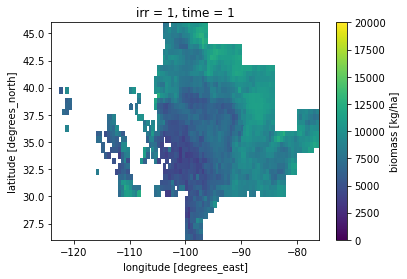

In [7]:
#First plotting... some examples
data2.biomass[0,0,0,0:,0:].plot(yincrease=True,vmin=0, vmax=20000, x='lon', y='lat')

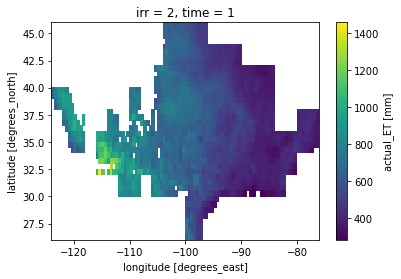

In [8]:
#First plotting... some examples
data2.actual_ET[0,0,1,0:,0:].plot(yincrease=True, x='lon', y='lat')

In [410]:
data2.biomass.quantile([0.005, 0.5, 1])

<xarray.DataArray 'biomass' (quantile: 3)>
array([ 4754.91360596, 13249.59960938, 27886.69921875])
Coordinates:
  * quantile  (quantile) float64 0.005 0.5 1.0

In [411]:
data2.biomass.min()

<xarray.DataArray 'biomass' ()>
array(0.)

(array([   784.,   4042.,  30217.,  77914., 110250., 103602.,  48362.,
         11491.,   1472.,    128.]),
 array([    0.  ,  2788.67,  5577.34,  8366.01, 11154.68, 13943.35,
        16732.02, 19520.69, 22309.36, 25098.03, 27886.7 ], dtype=float32),
 <a list of 10 Patch objects>)

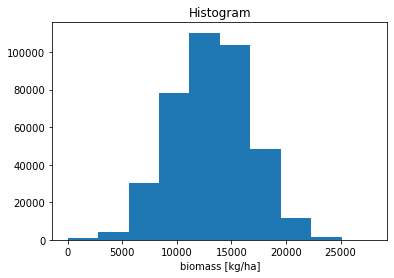

In [412]:
data2.biomass.plot.hist()

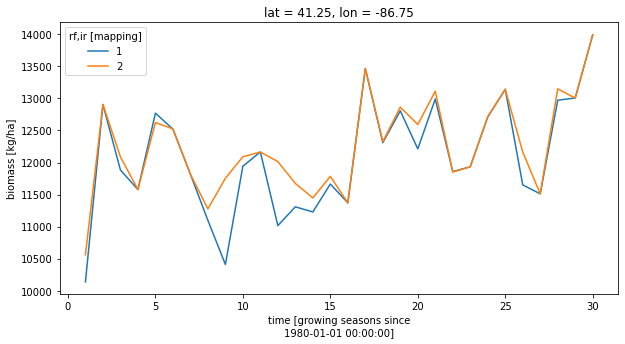

In [413]:
#Interannual variability of yield for a given lat/lon (Purdue Uni) and for both irrigation scenarios
data2.biomass.isel(lon=74, lat=9, scen_new=0).plot.line(x="time", hue="irr",figsize=(10,5))

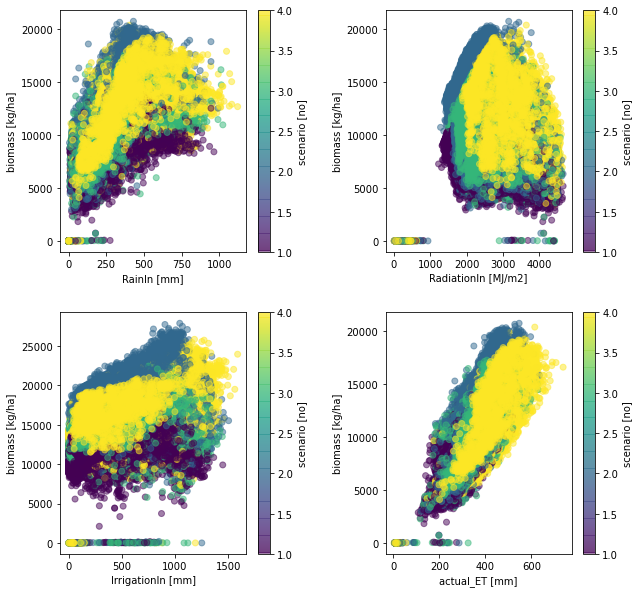

In [39]:
#Explore relationships between variables included in the multidimensional dataframe

data_dry = data2.where(data2['irr'] == 1)
data_irr = data2.where(data2['irr'] == 2)

fig = plt.figure(figsize=(10,10))

ax=plt.subplot(2, 2, 1)
data_dry.plot.scatter(x="RainIn", y="biomass", hue="scen", alpha=0.5)
ax=plt.subplot(2, 2, 2)
data_dry.plot.scatter(x="RadiationIn", y="biomass", hue="scen", alpha=0.5)
ax=plt.subplot(2, 2, 3)
data_irr.plot.scatter(x="IrrigationIn", y="biomass", hue="scen", alpha=0.5)
ax=plt.subplot(2, 2, 4)
data_dry.plot.scatter(x="actual_ET", y="biomass", hue="scen", alpha=0.5)

plt.subplots_adjust(wspace=0.4, hspace=0.25)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\fig2.png', dpi=300,bbox_inches='tight')

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


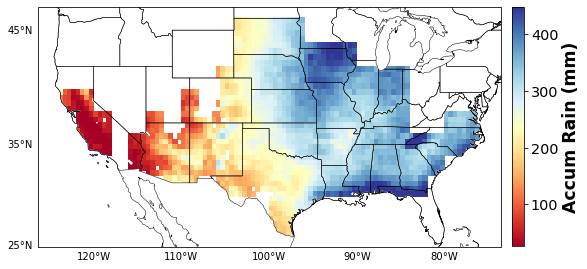

In [261]:
#Plotting single map with mean accum rain

fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

im=data2.RainIn.mean(dim=('time','scen_new','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu, add_colorbar=False, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']


gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
ax.coastlines(color='black',linewidth=0.5, zorder=4)
ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
gl.ylocator = mticker.FixedLocator([25, 35, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
area(ax, value, "white")
    
for value in iso3 :
    area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(im, orientation="vertical", pad=0.02, shrink=0.55)
cb.set_label(label='Accum Rain (mm)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='x-large')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\rain.png', dpi=300, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


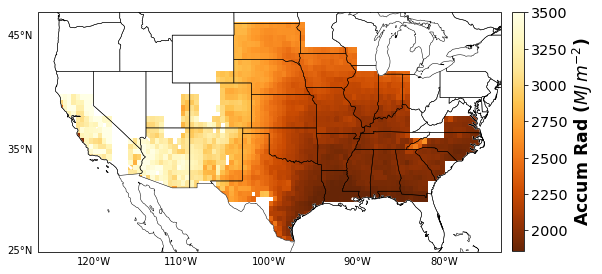

In [260]:
#Plotting single map with mean accum radiation

fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

im=data2.RadiationIn.mean(dim=('time','scen_new','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.YlOrBr_r, add_colorbar=False, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
ax.coastlines(color='black',linewidth=0.5, zorder=4)
ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
gl.ylocator = mticker.FixedLocator([25, 35, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
area(ax, value, "white")
    
for value in iso3 :
    area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(im, orientation="vertical", pad=0.02, shrink=0.55)
cb.set_label(label='Accum Rad ($MJ\,m^{-2}$)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='x-large')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\rain.png', dpi=300, bbox_inches='tight', pad_inches=0)

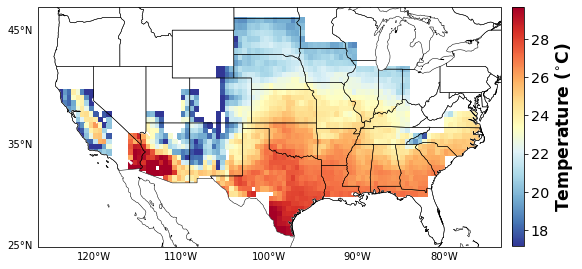

In [551]:
#Plotting single map with mean temperature during the growing cycle

fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

im=data2.TempIn.mean(dim=('time','scen_new','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True,
cmap=mpl.cm.RdYlBu_r, zorder=1, add_colorbar=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']


gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
ax.coastlines(color='black',linewidth=0.5, zorder=4)
ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
gl.ylocator = mticker.FixedLocator([25, 35, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
area(ax, value, "white")
    
for value in iso3 :
    area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(im, orientation="vertical", pad=0.02, shrink=0.55)
cb.set_label(label='Temperature ($^{\circ}$C)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='x-large')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\rain.png', dpi=300, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


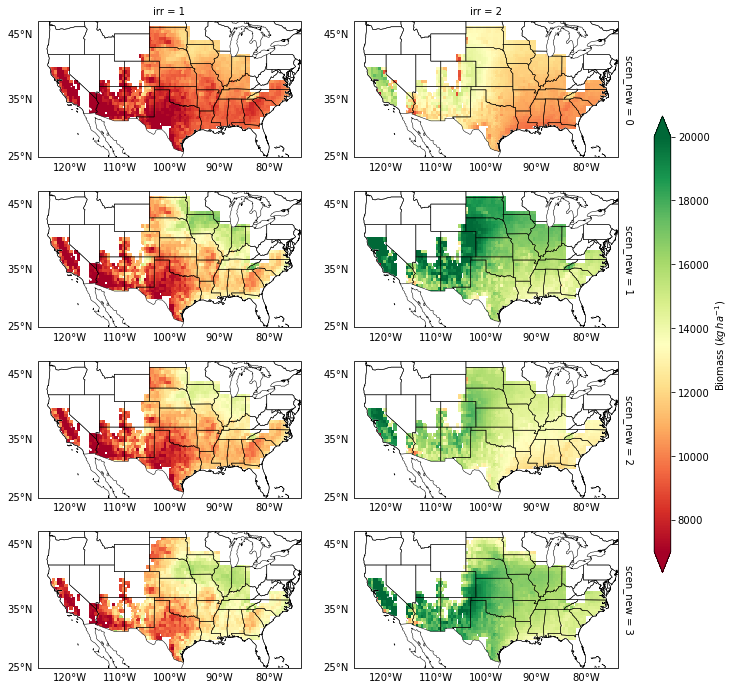

In [34]:
#Plotting mean biomass

map_proj = ccrs.Mercator(central_longitude=-95)

p = data2.biomass.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', col='irr', row='scen_new', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=7000, vmax=20000,
    figsize=(13,12), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

for value in iso3 :
    area(ax, value, "white")

for ax in p.axes.flat:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
    ax.coastlines(color='black',linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    area(ax, value, "white")
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels =False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.ylocator = mticker.FixedLocator([25, 35, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\biomass_all.png', dpi=300, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


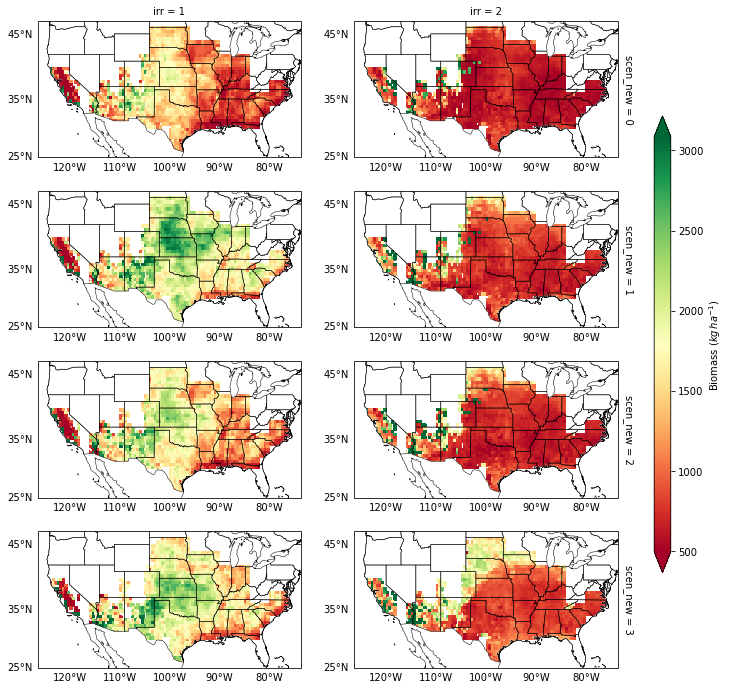

In [37]:
#Plotting standar deviation of biomass

map_proj = ccrs.Mercator(central_longitude=-95)

p = data2.biomass.std(dim=('time'), skipna=True).plot(x='lon', y='lat', col='irr', row='scen_new', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, #vmin=7000, vmax=20000,
    figsize=(13,12), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

for value in iso3 :
    area(ax, value, "white")

for ax in p.axes.flat:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
    ax.coastlines(color='black',linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    area(ax, value, "white")
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels =False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.ylocator = mticker.FixedLocator([25, 35, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\biomass_all.png', dpi=300, bbox_inches='tight', pad_inches=0)

## Work with 2D pandas dataframe and correlations

In [536]:
#Conver multidimendional frame to 2D frame
data2pd = data2.to_dataframe()
df = data2pd[data2pd.biomass != 0]
df.reset_index(level=[0,1,2,3,4], inplace=True)

#Change name of column
df.rename(columns={'scen_new':'cultivar'}, inplace=True)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [548]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='TempIn'
x='biomass'

#Set index
df1 = df.set_index(['lat','lon','cultivar','irr'])

a=df1.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4','biomass'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

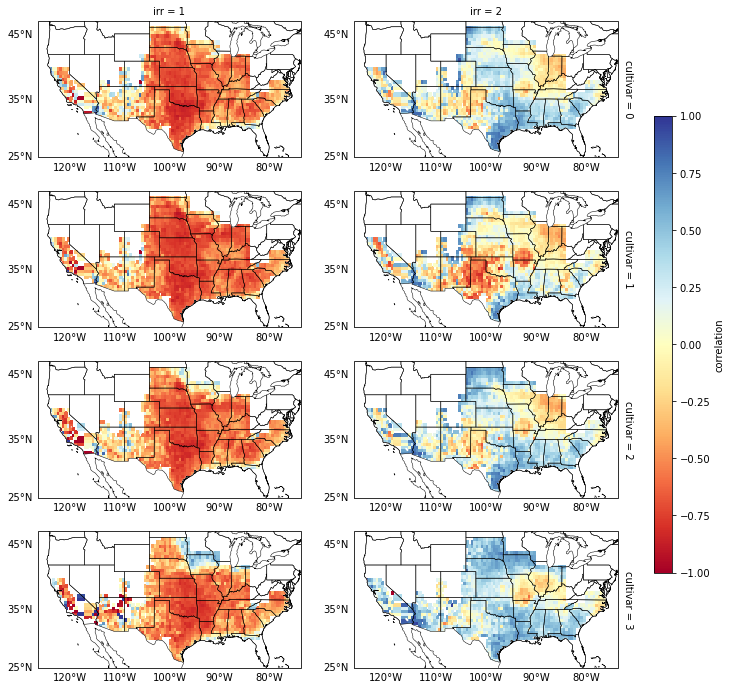

In [549]:
#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.TempIn.plot(x='lon', y='lat', col='irr', row='cultivar', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(13,12), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

for value in iso3 :
    area(ax, value, "white")

for ax in p.axes.flat:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
    ax.coastlines(color='black',linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    area(ax, value, "white")
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels =False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.ylocator = mticker.FixedLocator([25, 35, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\biomass_all.png', dpi=300, bbox_inches='tight', pad_inches=0)

## Heatmap and correlations

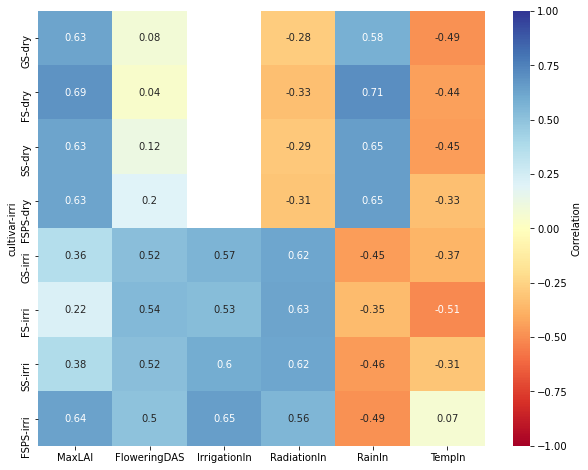

In [547]:
#Create dataframes by irrigation and cultivar

#Remove nan values
df1 = df.dropna()

#Create filters and rearrange dataframes
dry = df1.loc[df1['irr'] == 1]
irri = df1.loc[df1['irr'] == 2]

GSd = dry.loc[dry['cultivar'] == 0]
FSd = dry.loc[dry['cultivar'] == 1]
SSd = dry.loc[dry['cultivar'] == 2]
FSPSd = dry.loc[dry['cultivar'] == 3]

GSi = irri.loc[irri['cultivar'] == 0]
FSi = irri.loc[irri['cultivar'] == 1]
SSi = irri.loc[irri['cultivar'] == 2]
FSPSi = irri.loc[irri['cultivar'] == 3]

GSdcorr = GSd.corr().loc[['biomass'],['MaxLAI','FloweringDAS','IrrigationIn','RadiationIn','RainIn','TempIn']]
GSdcorr['cultivar'] = 'GS'
GSdcorr['irri'] = 'dry'
FSdcorr = FSd.corr().loc[['biomass'],['MaxLAI','FloweringDAS','IrrigationIn','RadiationIn','RainIn','TempIn']]
FSdcorr['cultivar'] = 'FS'
FSdcorr['irri'] = 'dry'
SSdcorr = SSd.corr().loc[['biomass'],['MaxLAI','FloweringDAS','IrrigationIn','RadiationIn','RainIn','TempIn']]
SSdcorr['cultivar'] = 'SS'
SSdcorr['irri'] = 'dry'
FSPSdcorr = FSPSd.corr().loc[['biomass'],['MaxLAI','FloweringDAS','IrrigationIn','RadiationIn','RainIn','TempIn']]
FSPSdcorr['cultivar'] = 'FSPS'
FSPSdcorr['irri'] = 'dry'

GSicorr = GSi.corr().loc[['biomass'],['MaxLAI','FloweringDAS','IrrigationIn','RadiationIn','RainIn','TempIn']]
GSicorr['cultivar'] = 'GS'
GSicorr['irri'] = 'irri'
FSicorr = FSi.corr().loc[['biomass'],['MaxLAI','FloweringDAS','IrrigationIn','RadiationIn','RainIn','TempIn']]
FSicorr['cultivar'] = 'FS'
FSicorr['irri'] = 'irri'
SSicorr = SSi.corr().loc[['biomass'],['MaxLAI','FloweringDAS','IrrigationIn','RadiationIn','RainIn','TempIn']]
SSicorr['cultivar'] = 'SS'
SSicorr['irri'] = 'irri'
FSPSicorr = FSPSi.corr().loc[['biomass'],['MaxLAI','FloweringDAS','IrrigationIn','RadiationIn','RainIn','TempIn']]
FSPSicorr['cultivar'] = 'FSPS'
FSPSicorr['irri'] = 'irri'

frames = [GSdcorr,FSdcorr,SSdcorr,FSPSdcorr,GSicorr,FSicorr,SSicorr,FSPSicorr]
corr = pd.concat(frames)
corr.reset_index(level=[0], inplace=True)

df_final=corr.drop(['index'], axis=1)
df1 = df_final.set_index(['cultivar','irri'])
df2 = df1.round(decimals=2)

#Plot heatmap
fig= plt.figure(figsize=(10,8))
sns.heatmap(df2, annot=True, cmap='RdYlBu',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\figs\corr.png', dpi=300, bbox_inches='tight', pad_inches=0)

## Others

In [96]:
df_mean = df.groupby(['irr', 'lat', 'lon', 'cultivar'],as_index=False).mean()
df_std = df.groupby(['irr', 'lat', 'lon', 'cultivar'],as_index=False).std()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1269: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


In [525]:
df[df.biomass < 3500]

,irr,lat,lon,cultivar,time,DaysAfterSowing,ExtinctionCoef,FertiliserIn,FloweringDAS,IrrigationIn,...,TT,TempIn,WaterUse,actual_ET,biomass,planting_date,scen,sw_stress_expan,sw_stress_photo,yield
96743,1,41.75,-104.75,0,24,146.0,0.60,200.0,0.0,0.000000,...,304.112000,18.712999,0.401000,183.078003,38.299999,135.0,1.0,0.890,0.890,0.0
96746,1,41.75,-104.75,0,27,146.0,0.60,200.0,0.0,0.000000,...,307.687988,18.865000,84.188004,247.800003,3269.000000,135.0,1.0,0.623,0.623,0.0
119660,1,40.75,-105.25,0,21,157.0,0.60,200.0,0.0,0.000000,...,177.475006,17.322001,1.547000,175.209000,83.500000,136.0,1.0,0.981,0.981,0.0
131161,1,40.25,-105.25,0,2,153.0,0.60,200.0,0.0,0.000000,...,307.112000,17.326000,0.537000,239.093002,41.900002,135.0,1.0,0.987,0.987,0.0
131191,1,40.25,-105.25,1,2,147.0,0.67,200.0,0.0,0.000000,...,303.500000,17.608999,0.597000,232.972000,44.500000,135.0,2.0,0.986,0.986,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726463,2,34.25,-119.75,3,22,12.0,0.38,100.0,0.0,58.381001,...,309.799988,17.605000,0.006000,58.381001,16.400000,135.0,4.0,0.750,0.750,0.0
726465,2,34.25,-119.75,3,24,14.0,0.38,100.0,0.0,75.976997,...,301.263000,17.650000,0.003000,75.976997,16.200001,135.0,4.0,0.500,0.500,0.0
740822,2,33.75,-107.75,2,28,190.0,0.56,200.0,0.0,571.681030,...,57.588001,16.853001,0.030000,767.500977,17.400000,135.0,3.0,0.989,0.989,0.0
752159,2,33.25,-108.25,2,12,210.0,0.56,200.0,0.0,572.625000,...,309.174988,14.930000,0.064000,845.401001,18.900000,135.0,3.0,0.976,0.976,0.0


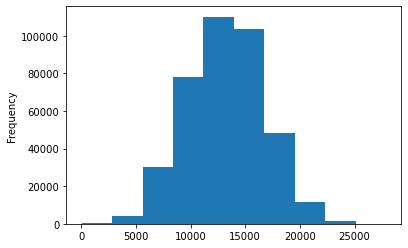

In [526]:
df.biomass.plot.hist()

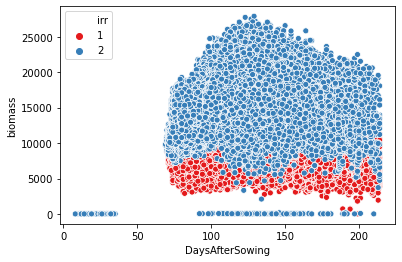

In [515]:
sns.scatterplot(x="DaysAfterSowing", y="biomass",hue='irr', data=df, palette='Set1')

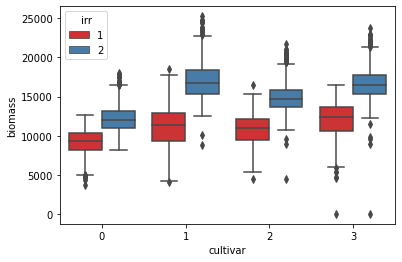

In [99]:
kwargs  =   {'edgecolor':"k"}
sns.boxplot(x="cultivar", y="biomass",hue='irr', data=df_mean, palette='Set1')

In [414]:
#sns.pairplot(df_mean, hue='cultivar', vars=['biomass', 'yield','IrrigationIn', 'FloweringDAS', 'MaxLAI', 'RainIn', 'TempIn', 'RadiationIn',
#       'WaterUse', 'actual_ET'])

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


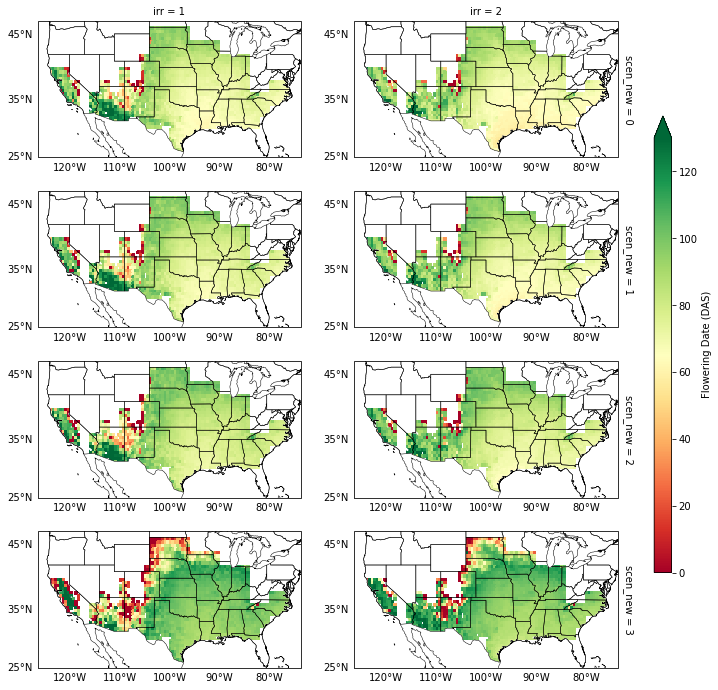

In [305]:
#Plotting FloweringDas

map_proj = ccrs.Mercator(central_longitude=-95)

p = data2.FloweringDAS.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', col='irr', row='scen_new', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=0, vmax=130,
    figsize=(13,12), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Flowering Date (DAS)"}, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

for ax in p.axes.flat:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
    ax.coastlines(color='black',linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    area(ax, value, "white")
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels =False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.ylocator = mticker.FixedLocator([25, 35, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    
for value in iso3 :
    area(ax, value, "white")
    
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\biomass_all.png', dpi=300, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


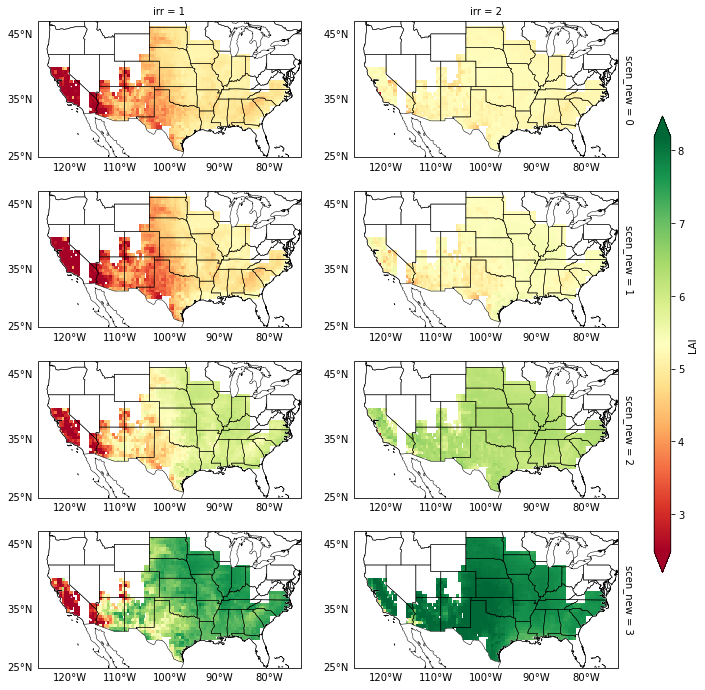

In [306]:
#Plotting MaxLAI

map_proj = ccrs.Mercator(central_longitude=-95)

p = data2.MaxLAI.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', col='irr', row='scen_new', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, #vmin=7000, vmax=20000,
    figsize=(13,12), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "LAI"}, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

for ax in p.axes.flat:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
    ax.coastlines(color='black',linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    area(ax, value, "white")
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels =False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.ylocator = mticker.FixedLocator([25, 35, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    
for value in iso3 :
    area(ax, value, "white")
    
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\biomass_all.png', dpi=300, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


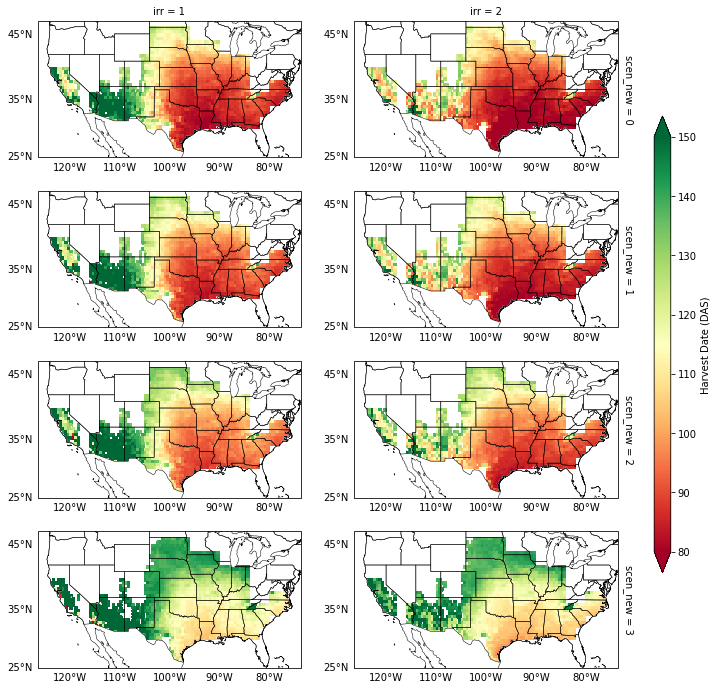

In [327]:
#Plotting biomass

map_proj = ccrs.Mercator(central_longitude=-95)

p = data2.DaysAfterSowing.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', col='irr', row='scen_new', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=80, vmax=150,
    figsize=(13,12), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Harvest Date (DAS)"}, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

for ax in p.axes.flat:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
    ax.coastlines(color='black',linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    area(ax, value, "white")
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels =False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.ylocator = mticker.FixedLocator([25, 35, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    
for value in iso3 :
    area(ax, value, "white")
    
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\biomass_all.png', dpi=300, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


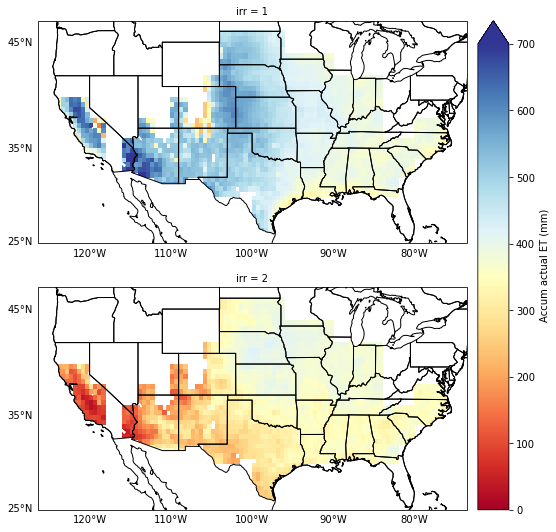

In [161]:
#Plotting actual_ET

map_proj = ccrs.Mercator(central_longitude=-95)

p = data2.actual_ET.mean(dim=('time'), skipna=True).plot(col='irr', col_wrap=1, transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=0, vmax=700,
    figsize=(10,9), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 15,
        "pad": 0.02,
        "label": "Accum actual ET (mm)"}, zorder=1)
def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

for ax in p.axes.flat:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
    ax.coastlines(color='black',linewidth=1, zorder=4)
    ax.add_feature(cfeature.STATES,linewidth=1, zorder=3)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    area(ax, value, "white")
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels =False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.ylocator = mticker.FixedLocator([25, 35, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    
for value in iso3 :
    area(ax, value, "white")

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\et.png', dpi=300, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


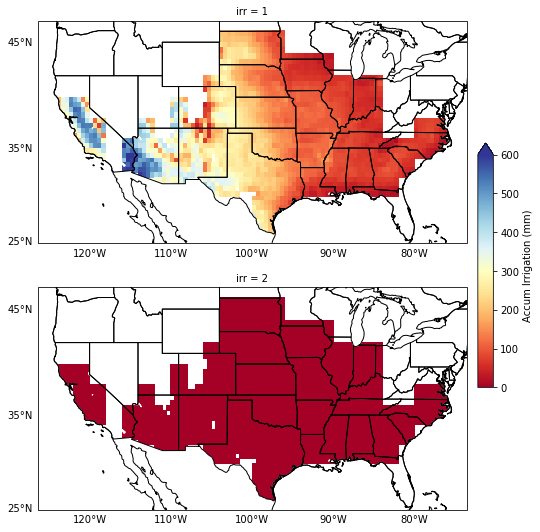

In [156]:
#Plotting actual_ET

map_proj = ccrs.Mercator(central_longitude=-95)

p = data2.IrrigationIn.mean(dim=('time'), skipna=True).plot(col='irr', col_wrap=1, transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=0, vmax=600,
    figsize=(10,9), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.5,
        "aspect": 15,
        "pad": 0.02,
        "label": "Accum Irrigation (mm)"}, zorder=1)
def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

for ax in p.axes.flat:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
    ax.coastlines(color='black',linewidth=1, zorder=4)
    ax.add_feature(cfeature.STATES,linewidth=1, zorder=3)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    area(ax, value, "white")
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels =False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.ylocator = mticker.FixedLocator([25, 35, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    
for value in iso3 :
    area(ax, value, "white")

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\irri.png', dpi=300, bbox_inches='tight', pad_inches=0)

''

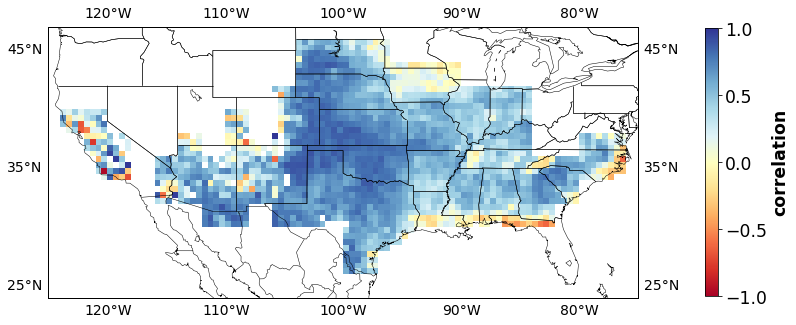

In [501]:
#Plot correlations using scatter plot and basemap
#Calculate correlation between defined variables
""""
x='biomass'
y='RainIn'

a=df1.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4','biomass'], axis=1)
#Drop duplicates
df = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Create list of values for mapping using scatter plot

GSd = df[(df.cultivar == 0) & (df.irr == 1)]
GSd_lon = GSd['lon'].values
GSd_lat = GSd['lat'].values
GSd_y = GSd[y].values

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
os.environ["PROJ_LIB"] = r'C:\Users\uqjojeda\Anaconda3\Library\share'
from mpl_toolkits.basemap import Basemap

fig= plt.figure(figsize=(12,5))

ax=plt.subplot(1, 1, 1)
# set Basemap with slightly larger extents
# set resolution at intermediate level "i"
m = Basemap(projection='cyl', llcrnrlon=-125, llcrnrlat=24, urcrnrlon=-75, urcrnrlat=47, resolution='l')
#m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
m.drawmapboundary(fill_color='white')
m.drawstates(color="k", linewidth=0.5)
m.drawcoastlines(color="k", linewidth=0.5)
m.drawcountries(color="k", linewidth=0.5)
# labels = [left,right,top,bottom]
parallels = (25,35,45)
m.drawparallels(parallels,labels=[True,True,True],linewidth=0,size=14)
meridians = (-80, -90,-100,-110, -120)
m.drawmeridians(meridians,labels=[True,True,True,True,True],linewidth=0,size=14)
# plot points using color for heat data and size for altitude
m.scatter(GSd_lon, GSd_lat, latlon=True, c=GSd_y, alpha=1, s=35, cmap='RdYlBu', linewidths=0, zorder=1, marker=',')

# create colorbar and legend
cb=plt.colorbar(drawedges=False, fraction=0.02, pad=0.1)
cb.set_label(label='correlation', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')
plt.clim(-1, 1)
cb.set_alpha(1)
cb.draw_all()
#cb.remove()

#ax.set_title('BrC (242)',fontsize= 20,weight='bold') 
#ax.title.set_position([0.5,1.06])
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\harvest\TT\2_.png', dpi=600, bbox_inches='tight', pad_inches=0.0)